# Analyse de la prévalence de la maladie

## Nettoyage des données

Préambule

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams['figure.dpi'] = 100

Chargement des données

In [2]:
from getting_started import df_patient, df_pcr, pd

df_patient = df_patient.convert_dtypes()
df_pcr = df_pcr.convert_dtypes()

Nettoyage et rapprochement

In [3]:
from entity_resolution import detect_duplicates

df_patient = detect_duplicates(df_patient)

df_patient[df_patient.dedup_id.duplicated(keep=False)].sort_values("dedup_id")

,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2,dedup_id
patient_id,,,,,,,,,,,,
249333,spyke,thwaithe,3,port jackson circuit,narrandera,6170,wa,1993-09-21,29,04 77967463,bonholme,100215
944846,spyke,thwaite,3,port jackson circuit,narrandera,6107,wa,1993-09-21,29,04 77967463,<NA>,100215
455752,mitchdkl,bishop,27,chevalier street,<NA>,2010,nsw,1999-01-07,19,02 26075601,<NA>,102187
102187,mitchell,bishop,27,chevalier street,<NA>,2010,nsw,1999-07-07,19,02 26075601,<NA>,102187
493920,mitcehll,bishop,28,chevalier street,<NA>,2014,nsw,1999-07-07,19,02 26075601,<NA>,102187
...,...,...,...,...,...,...,...,...,...,...,...,...
997849,cooper,large,15,holden crescent,dandenong north,4660,qld,NaT,24,03 62466059,school residence,997849
534034,benjamin,mizon,14,derry street,frenchs forest,5095,sa,1933-01-05,<NA>,02 15230330,<NA>,997883
997883,benjamin,mizon,19,derry street,frenchs f orest,5095,sa,1933-01-05,<NA>,02 15230330,<NA>,997883


Taux de rapprochement

In [4]:
100 * len(df_patient[df_patient.dedup_id.duplicated(keep=False)]) / len(df_patient)

9.440220441904373

Conversion des résultats de test PCR en variable catégorielle

In [5]:
df_pcr.pcr = pd.Categorical(df_pcr.pcr.str[0], categories=["N", "P"], ordered=True)

df_pcr.pcr.value_counts()

N    6616
P    2184
Name: pcr, dtype: int64

Fusion de l'échantillons de tests PCR avec le référentiel patient

In [6]:
df_prevalence = (
    df_pcr.merge(
        df_patient.dedup_id,
        left_on="patient_id",
        right_index=True,
        validate="m:1",
    )
    .drop(columns="patient_id")
    .groupby("dedup_id").max()
    .rename_axis("patient_id")
    .rename(columns={"pcr": "affected"})
    .join(df_patient)
    .drop(columns="dedup_id")
)

df_prevalence.affected.value_counts()

N    6286
P    2128
Name: affected, dtype: int64

## Prévalence par catégorie d'âge

In [7]:
df_prevalence["age_category"] = (
    pd.cut(
        df_prevalence.age,
        bins=[0, 10, 20, 30, 40, 100],
        include_lowest=True,
        ordered=True,
    )
)

df_prevalence_age = (
    df_prevalence[["age_category", "affected"]]
    .replace({"affected": {"N": 0, "P": 1}})
    .groupby("age_category").agg(["sum", "count"])
    .droplevel(level=0, axis="columns")
    .rename(columns={"sum": "affected", "count": "tested"})
)

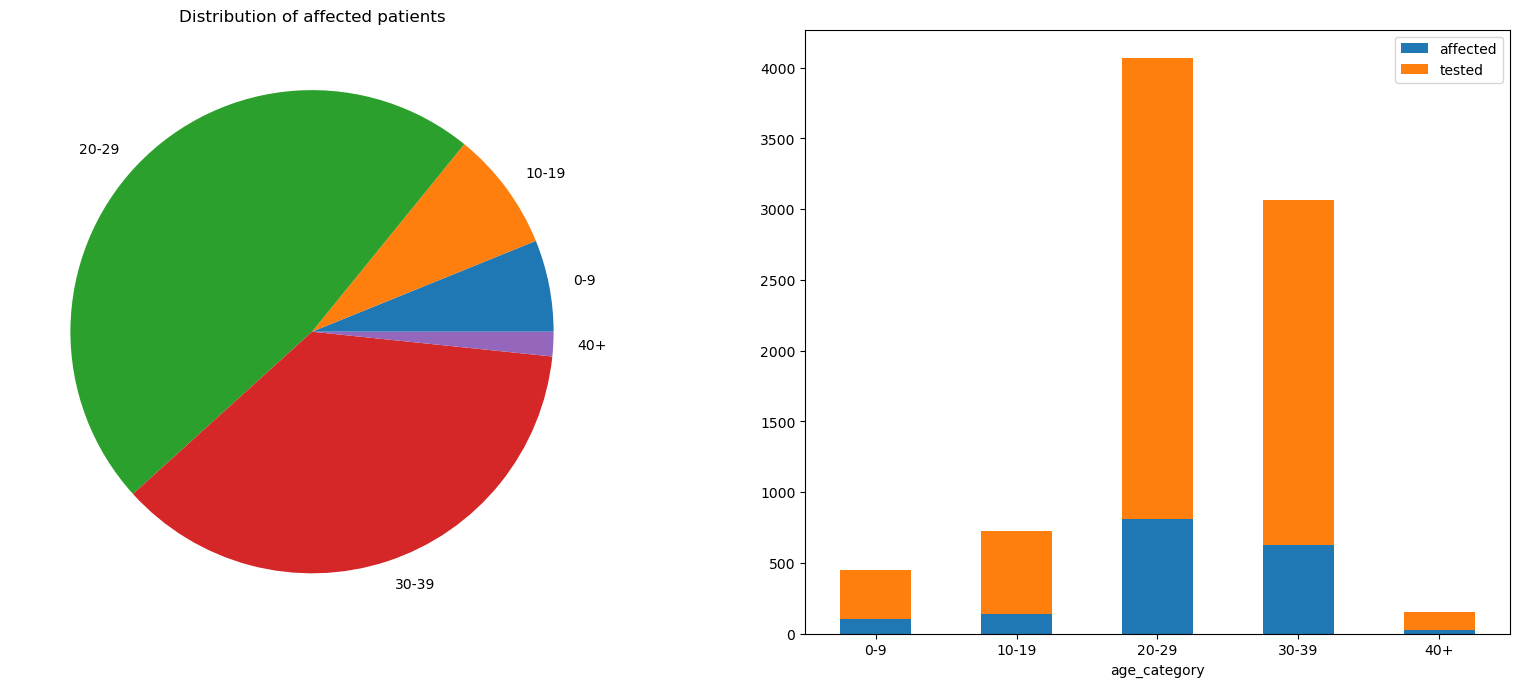

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 8))
labels = ["0-9", "10-19", "20-29", "30-39", "40+"]
df_prevalence_age.affected.plot.pie(ax=ax[0], labels=labels)
ax[0].set_title("Distribution of affected patients")
ax[0].yaxis.set_visible(False)
df_prevalence_age.plot.bar(stacked=True, rot=False, ax=ax[1])
_ = ax[1].xaxis.set_ticklabels(labels)

## Prévalence par état

In [9]:
df_prevalence_state = (
    df_prevalence[["state", "affected"]]
    .replace({"affected": {"N": 0, "P": 1}})
    .groupby("state").agg(["sum", "count"])
    .droplevel(level=0, axis="columns")
    .rename(columns={"sum": "affected", "count": "tested"})
)

<AxesSubplot:xlabel='state'>

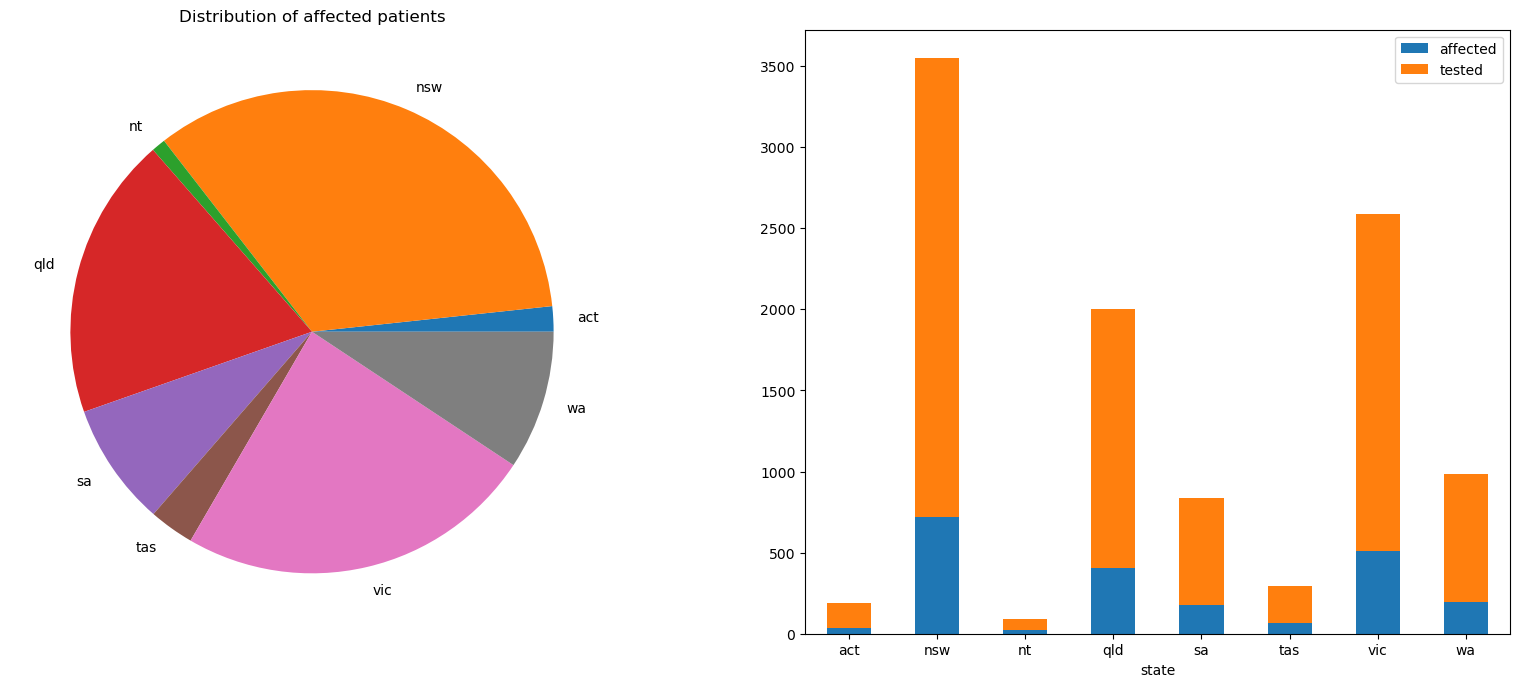

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 8))
df_prevalence_state.affected.plot.pie(ax=ax[0])
ax[0].set_title("Distribution of affected patients")
ax[0].yaxis.set_visible(False)
df_prevalence_state.plot.bar(stacked=True, rot=False, ax=ax[1])

## Cartographie de la prévalence

Préparation du Choropleth

In [11]:
from ipyleaflet import Choropleth
from branca.colormap import linear
import json

geo_data = json.load(open("aus_state.geojson"))

choro_data = (
    df_prevalence_state["affected"]
    .rename(index={
        "nsw": 0,
        "vic": 1,
        "qld": 2,
        "sa": 3,
        "wa": 4,
        "tas": 5,
        "nt": 6,
        "act": 7
    })
).to_dict()

choro_data[8] = 0   # Other territories

choropleth = Choropleth(
    geo_data=geo_data,
    choro_data=choro_data,
    colormap=linear.YlOrRd_04,
    style={'fillOpacity': 0.6, 'dashArray': '5, 5'},
    name="choropleth"
)

Préparation des foyers d'infection

In [12]:
from ipyleaflet import AwesomeIcon, Marker, MarkerCluster

locations = (
    pd.read_csv(
        "australian_postcodes.csv",
        index_col="id",
        usecols=("id","postcode", "long", "lat"),
        dtype={
            "id": "int64",
            "postcode": "str",
            "long": "float",
            "lat": "float",
        }
    )
    .rename(columns={"long": "longitude", "lat": "latitude"})
    .drop_duplicates("postcode", keep="first")
    .set_index("postcode")
)

locations = (
    df_prevalence.merge(locations, left_on="postcode", right_index=True)
    [["latitude", "longitude"]].values.tolist()
)

icon = AwesomeIcon(
    name="plus-square",
    icon_color="white",
    marker_color="black",
)

markers = [
    Marker(icon=icon, location=location)
    for location in locations
]

marker_cluster = MarkerCluster(markers=markers, name="clusters")

Composition de la carte interactive

In [13]:
from ipywidgets import Layout
from ipyleaflet import Choropleth, Map, basemaps
from ipyleaflet import LayersControl, SearchControl

# Base map
map_ = Map(
    basemap=basemaps.OpenStreetMap.BlackAndWhite,
    center=(-25.8, 136.8698),
    zoom=5,
    #scroll_wheel_zoom=True,
    layout=Layout(width="100%", height="800px")
)

# Layer control
layer_control = LayersControl(position="topleft")


# Search control
search_marker = Marker(icon=AwesomeIcon(name="cirle"))

search_control = SearchControl(
    position="topright",
    url="https://nominatim.openstreetmap.org/search?format=json&q={s}",
    zoom=10,
    marker=search_marker,
)

# Compose layers
map_.add_layer(choropleth)
map_.add_layer(marker_cluster)

# Compose controls
map_.add_control(layer_control)
map_.add_control(search_control)

# Display map
map_

Map(center=[-25.8, 136.8698], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…